Get fields from Lumerical and save in file for later

NOTE: On this file I look for the first 4 modes, regardless of their type.

In [14]:
import lumerical as lum
import numpy as  np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import imp
import time
import matplotlib.patches as patches

np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [15]:
lumapi = imp.load_source("lumapi", "C:/Program Files/Lumerical/2020a/api/python/lumapi.py")
MODE = lumapi.MODE("Template_Luis.lms")

Units

In [3]:
from scipy.constants import pi, c
um = 1e-6
nm = 1e-9
THz = 1e12

Materials

In [4]:
material_substrate = "SiO2_analytic"
material_thinfilm = "LN_analytic_MgO_doped_xne"

Main waveguide parameters

slab = 0.700 um
width at the base = 0.931 um


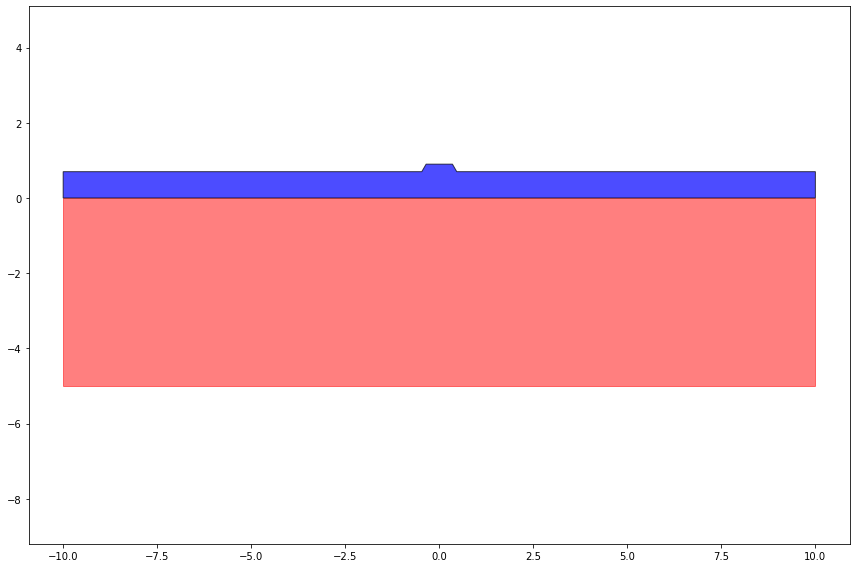

In [12]:
h_LN = 900*nm
h_etch = 200*nm
width_top = 0.7*um
theta = 60
h_slab = h_LN - h_etch

w_slab = 20*um
h_margin = 5*um
h_substrate = 5*um
meshsize = 50*nm
finemesh = 20*nm

wg_length = 10*um #Useless in MODE
width_top_base = width_top + 2*h_etch/np.tan(theta*pi/180)
w_sidewall = h_etch/np.tan(theta*pi/180)

print('slab = %.3f um' %(h_slab/um))
print('width at the base = %.3f um' %(width_top_base/um))

#Draw it
fig,ax = plt.subplots()
substrate = patches.Rectangle((-w_slab/2/um,-h_substrate/um), w_slab/um, h_substrate/um,
                             linewidth=1, edgecolor='r', facecolor='r', alpha=0.5)
v_ridge = np.array([[-width_top/2-w_sidewall,h_slab], [-width_top/2,h_LN],
                   [width_top/2,h_LN], [width_top/2+w_sidewall,h_slab],
                   [w_slab/2,h_slab], [w_slab/2,0], 
                   [-w_slab/2,0], [-w_slab/2, h_slab] ] )/um
ridge = patches.Polygon(v_ridge, linewidth=1, 
                       edgecolor='k', facecolor='blue', alpha=0.7)

ax.add_patch(substrate)
ax.add_patch(ridge)

plt.axis('equal')
plt.tight_layout()
plt.show()

Wavelength range

In [6]:
wl_start = 0.9*um
wl_stop = 2.5*um
f_start = c/wl_stop
f_stop = c/wl_start
f_step = 10*THz

freqs = np.arange(f_start, f_stop+1*THz, f_step)
wl = c/freqs

print('Lowest frequency = %0.1f THz (%0.1f um)' %(f_start/THz, wl_stop/um))
print('Highest frequency = %0.1f THz (%0.1f um)' %(f_stop/THz, wl_start/um))
print('')
print('Frequency list (THz)', (freqs/THz))
print('')
print('Wavelength list =', wl/um, ' um')

Lowest frequency = 119.9 THz (2.5 um)
Highest frequency = 333.1 THz (0.9 um)

Frequency list (THz) [ 119.917  129.917  139.917  149.917  159.917  169.917  179.917  189.917
  199.917  209.917  219.917  229.917  239.917  249.917  259.917  269.917
  279.917  289.917  299.917  309.917  319.917  329.917]

Wavelength list = [ 2.500  2.308  2.143  2.000  1.875  1.764  1.666  1.579  1.500  1.428
  1.363  1.304  1.250  1.200  1.153  1.111  1.071  1.034  1.000  0.967
  0.937  0.909]  um


Draw waveguide and setup solver

In [16]:
lum.draw_wg(MODE, material_thinfilm, material_substrate,
              h_LN, h_substrate, h_etch, width_top, w_slab, theta, wg_length)
lum.add_fine_mesh(MODE, finemesh, h_LN, width_top_base, x_factor=1.2, y_factor=1.5)
lum.add_2D_mode_solver(MODE, meshsize, h_LN, h_substrate, 
                         w_slab, wg_length, h_margin)

In [8]:
nmodes = 4 #will save first 4 modes only

modes = np.empty( (wl.size, nmodes), dtype=object)
neff = np.empty( (wl.size, nmodes) )
ng = np.empty( (wl.size, nmodes) )
loss = np.empty( (wl.size, nmodes) )
tepf = np.empty( (wl.size, nmodes) )

neff[:] = np.nan
ng[:] = np.nan
loss[:] = np.nan
tepf[:] = np.nan

tic = time.time()
for kw in range(wl.size):
    MODE.switchtolayout()
    _neff, _ng, _loss, _tepf = lum.solve_mode(MODE, wl[kw], nmodes=10)
    
    m = min(_ng.size, nmodes)
    
    for km in range(m): #Look for first the first four modes

        if _loss[km]<1e-5:
            M = lum.mode()
            M.get_from_lumerical(MODE, km+1)
            modes[kw, km] = M
            neff[kw, km] = _neff[km]
            ng[kw, km]   = _ng[km]
            loss[kw, km] = _loss[km]
            tepf[kw, km] = _tepf[km]

    print('Wavelength %0.3f um completed' %(wl[kw]/um))
    
MODE.close()
total_time = (time.time() - tic)/60
print('Total time = %.1f  min' %(total_time))

#Save data
data_filename = 'Data\LNoI_%inm_%inm_%inm' %(int(h_LN/nm), int(h_etch/nm), 
                                                                int(width_top/nm))
data_filename = data_filename.replace('.','p')
np.savez(data_filename, modes=modes, neff=neff, ng=ng, loss=loss, tepf=tepf, wavelength=wl, #Main results
         h_LN=h_LN, h_etch=h_etch, width_top=width_top, #Setup stuff
         theta=theta, h_substrate=h_substrate, w_slab=w_slab, h_margin=h_margin, 
         mesh_size=meshsize, finemesh=finemesh, 
         material_substrate=material_substrate, material_thinfilm=material_thinfilm)

Wavelength 2.500 um completed
Wavelength 2.308 um completed
Wavelength 2.143 um completed
Wavelength 2.000 um completed
Wavelength 1.875 um completed
Wavelength 1.764 um completed
Wavelength 1.666 um completed
Wavelength 1.579 um completed
Wavelength 1.500 um completed
Wavelength 1.428 um completed
Wavelength 1.363 um completed
Wavelength 1.304 um completed
Wavelength 1.250 um completed
Wavelength 1.200 um completed
Wavelength 1.153 um completed
Wavelength 1.111 um completed
Wavelength 1.071 um completed
Wavelength 1.034 um completed
Wavelength 1.000 um completed
Wavelength 0.967 um completed
Wavelength 0.937 um completed
Wavelength 0.909 um completed
Total time = 8.3  min


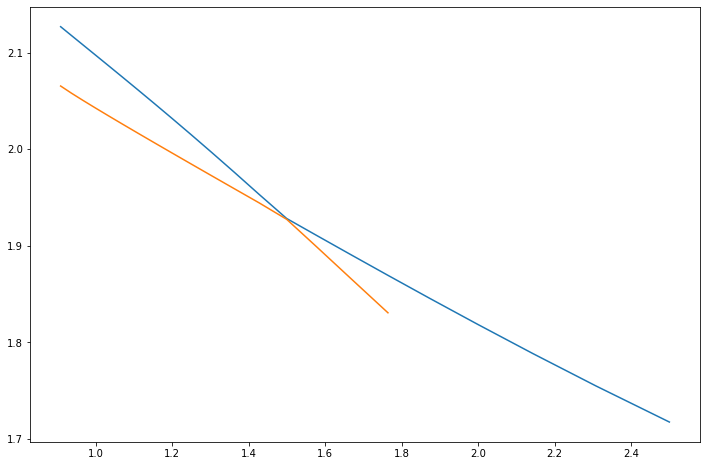

In [9]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.plot(wl/um, neff)

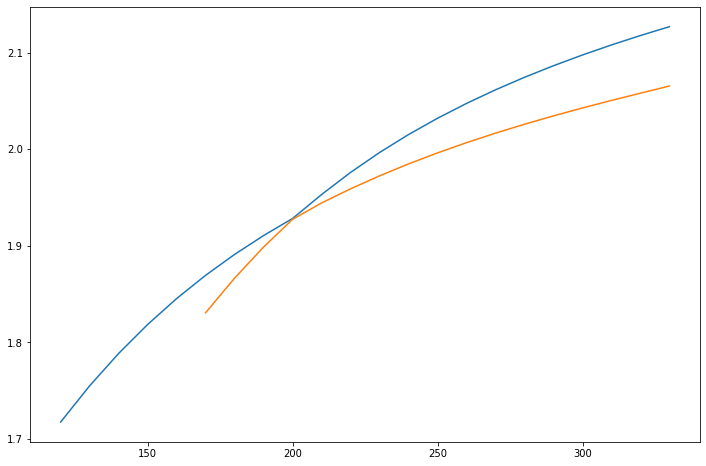

In [10]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.plot(freqs/THz, neff)

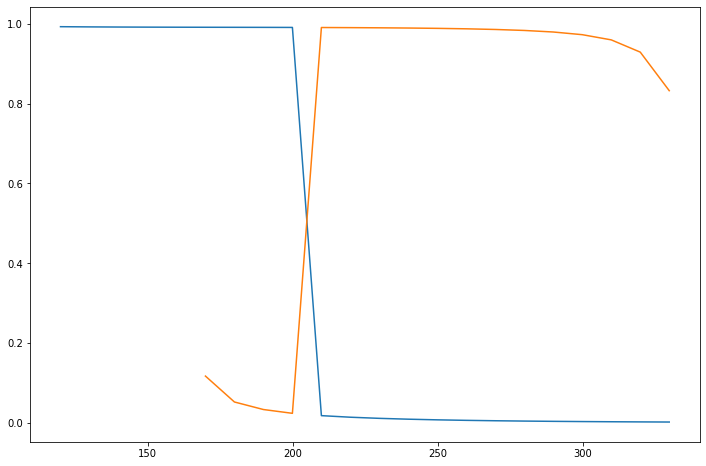

In [11]:
plt.plot(freqs/THz, tepf)